In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.data import imread
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/media/rutu/My Passport/all"))

# Any results you write to the current directory are saved as output.


['.~lock.train_ship_segmentations_v2.csv#', 'sample_submission_v2.csv', 'test_v2', 'test_v2.zip', 'train_ship_segmentations_v2.csv', 'train_v2', 'train_v2.zip']


In [3]:
train = os.listdir('/media/rutu/My Passport/all/train_v2')
print(len(train))

test = os.listdir('/media/rutu/My Passport/all/test_v2')
print(len(test))

192556
15606


In [4]:
submission = pd.read_csv('/media/rutu/My Passport/all/sample_submission_v2.csv')
submission.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [5]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [6]:


masks = pd.read_csv('/media/rutu/My Passport/all/train_ship_segmentations_v2.csv')
masks.head()



,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


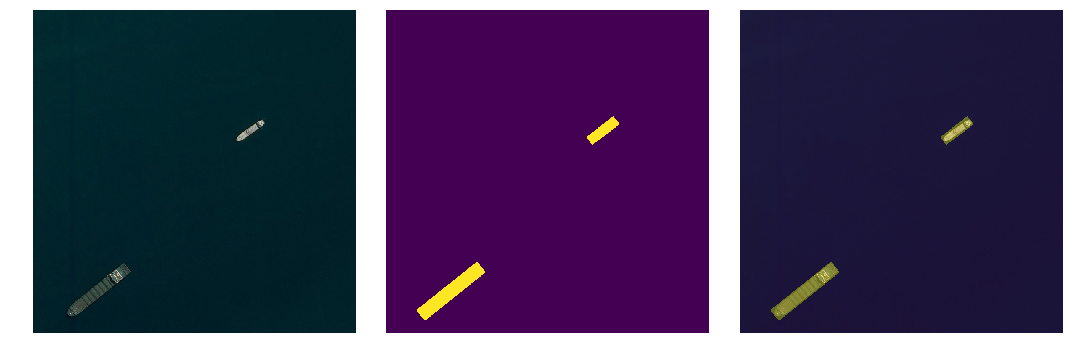

In [7]:
ImageId = '0005d01c8.jpg'

img = imread('/media/rutu/My Passport/all/train_v2/' + ImageId)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot & image processing
from skimage.morphology import label
from skimage.data import imread

import os
import time
import sys

# Configurations
# Split x ratio of train dataset for validation 
TRAINING_VALIDATION_RATIO = 0.2
WORKING_DIR = '/home/rutu'
INPUT_DIR = '/media/rutu/My Passport/all'
OUTPUT_DIR = '/media/rutu/My Passport/all'
LOGS_DIR = os.path.join(WORKING_DIR, "logs")
TRAIN_DATA_PATH = os.path.join(INPUT_DIR, 'train_v2')
TEST_DATA_PATH = os.path.join(INPUT_DIR, 'test_v2')
SAMPLE_SUBMISSION_PATH = os.path.join(INPUT_DIR, 'sample_submission_v2.csv')
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(INPUT_DIR, 'train_ship_segmentations_v2.csv')
MASK_RCNN_PATH = os.path.join(WORKING_DIR, 'Mask_RCNN-master')
COCO_WEIGHTS_PATH = os.path.join(WORKING_DIR, "mask_rcnn_coco.h5")
SHIP_CLASS_NAME = 'ship'
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)

test_ds = os.listdir(TEST_DATA_PATH)
train_ds = os.listdir(TRAIN_DATA_PATH)

print('Working Dir:', WORKING_DIR, os.listdir(WORKING_DIR))
print('Input Dir:', INPUT_DIR, os.listdir(INPUT_DIR))
print('train dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(train_ds)))
print('test dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(test_ds)))
print(TRAIN_SHIP_SEGMENTATIONS_PATH)

Working Dir: /home/rutu ['Untitled3.ipynb', '13.png', 'l8cloudmasks.zip', 'github', 'cloud', 'X_train.txt', 'Desktop', 'cragg-classes.txt', 'submissionall0.5and10_2.json', 'Templates', '11.png', 'postprocessing-deferrals', 'qmdp.txt', 'eclipse-workspace', 'AllFinal', 'DSP', 'team-cragg', 'submission0.05.json', 'new008.png', 'Ship.ipynb', 'team-cragg-develop', '.ipynb_checkpoints', 'hopper-nmf.ipynb', '14.png', '.atom', '.gsutil', '10.png', 'submissionall0.5and10_2_1.json', 'cloud_seg.ipynb', '.jupyter', 'submissionfinal.json', '.tooling', 'Untitled5.ipynb', '.p2', '.emacs.d', '1.png', 'Public', 'myscript', 'cragg-preproc.ipynb', 'README.txt', 'submissionall0.5and10_0.json', '.bashrc', 'mask2.tif', 'untitled1.json', 'Music', '.recently-used', 'mangalyaan.ipynb', 'raw_image.tif', '.bash_logout', 'team-cragg-develop.zip', 'count.py', '.keras', '.profile', 'Mask_RCNN-master', '.local', 'logistic_regression.py', 'DM', 'submission.json', 'submissionk10.json', 'Untitled4.ipynb', '.nv', 'dmanu

In [9]:
masks = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS_PATH)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


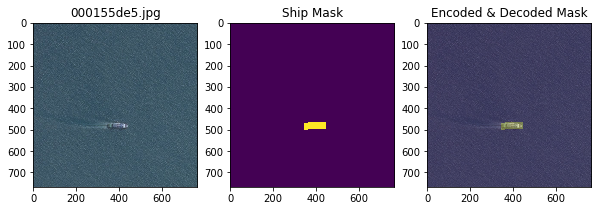

000155de5.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


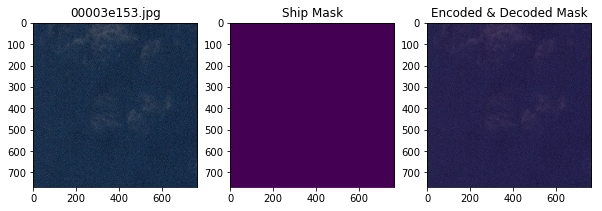

00003e153.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 0
It could be different when there is no mask.


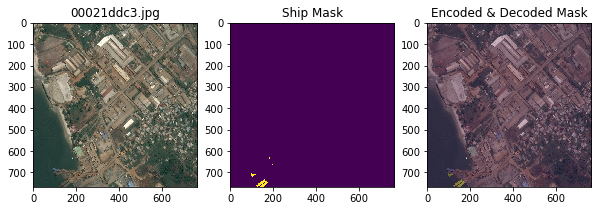

00021ddc3.jpg  Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
It could be different when there are masks overlapped.


In [10]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    '''
    # reshape to 1d array
    pixels = img.T.flatten() # Needed to align to RLE direction
    # pads the head & the tail with 0 & converts to ndarray
    pixels = np.concatenate([[0], pixels, [0]])
    # gets all start(0->1) & end(1->0) positions 
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    # transforms end positions to lengths
    runs[1::2] -= runs[::2]
    # converts to the string formated: '[s0] [l0] [s1] [l1]...'
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=SHAPE):
    '''
    mask_rle: run-length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    shape: (height,width) of array to return 
    Returns numpy array according to the shape, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    # gets starts & lengths 1d arrays 
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    # gets ends 1d array
    ends = starts + lengths
    # creates blank mask image 1d array
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    # sets mark pixles
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # reshape as a 2d mask image
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, shape=SHAPE):
    '''Take the individual ship masks and create a single mask array for all ships
    in_mask_list: pd Series: [idx0] [RLE string0]...
    Returns numpy array as (shape.h, sahpe.w, 1)
    '''
    all_masks = np.zeros(shape, dtype = np.int16)
    # if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_PATH):
    '''Show image, ship mask, and encoded/decoded result
    '''
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    # image
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    
    # input mask
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    # takes 2d array (shape.h, sahpe.w)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    
    # encode & decode mask 
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

# inspects a few example
shows_decode_encode('000155de5.jpg')
shows_decode_encode('00003e153.jpg')
print('It could be different when there is no mask.')
shows_decode_encode('00021ddc3.jpg')
print('It could be different when there are masks overlapped.')

unique_img_ids groupby took: 21.113759517669678


,ImageId,ships,RleMaskList
111711,9486d26d0.jpg,1,[190547 2 191315 5 192083 8 192850 12 193618 1...
87653,7459da01f.jpg,8,[90813 2 91580 4 92348 3 93115 3 93882 3 94649...
26834,23b3ad80a.jpg,1,[215160 2 215926 4 216692 7 217458 9 218224 12...


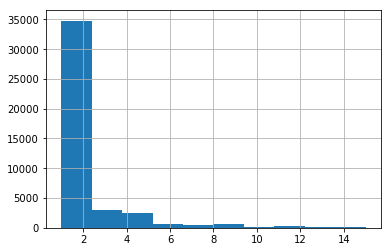

In [11]:
# check if a mask has a ship 
masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)
# sum ship# by ImageId and create the unique image id/mask list
start_time = time.time()
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))

# Only care image with ships
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)


34044 training masks
8512 validation masks


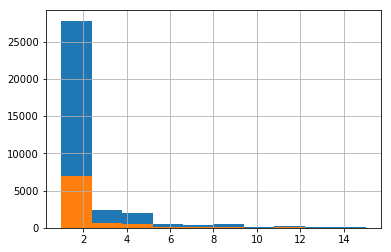

In [12]:
# split to training & validation sets 
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids, 
                 test_size = TRAINING_VALIDATION_RATIO, 
                 stratify = unique_img_ids['ships'])
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()

In [13]:
# if to clone Mask_R-CNN git when it exists 
UPDATE_MASK_RCNN = False

os.chdir(WORKING_DIR)
if UPDATE_MASK_RCNN:
    !rm -rf {MASK_RCNN_PATH}

# Downlaod Mask RCNN code to a local folder 
if not os.path.exists(MASK_RCNN_PATH):
    ! wget https://github.com/samlin001/Mask_RCNN/archive/master.zip -O Mask_RCNN-master.zip
    ! unzip Mask_RCNN-master.zip 'Mask_RCNN-master/mrcnn/*'
    ! rm Mask_RCNN-master.zip

# Import Mask RCNN
sys.path.append(MASK_RCNN_PATH)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log    

Using TensorFlow backend.


In [14]:
class AirbusShipDetectionChallengeDataset(utils.Dataset):
    """Airbus Ship Detection Challenge Dataset
    """
    def __init__(self, image_file_dir, ids, masks, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT):
        super().__init__(self)
        self.image_file_dir = image_file_dir
        self.ids = ids
        self.masks = masks
        self.image_width = image_width
        self.image_height = image_height
        
        # Add classes
        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()
        
    def load_dataset(self):
        """Load dataset from the path
        """
        # Add images
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            #print(rle_mask_list)
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

In [15]:
class AirbusShipDetectionChallengeGPUConfig(Config):
    """
    Configuration of Airbus Ship Detection Challenge Dataset 
    Overrides values in the base Config class.
    From https://github.com/samlin001/Mask_RCNN/blob/master/mrcnn/config.py
    """
    # https://www.kaggle.com/docs/kernels#technical-specifications
    NAME = 'ASDC_GPU'
    # NUMBER OF GPUs to use.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    NUM_CLASSES = 2  # ship or background
    IMAGE_MIN_DIM = IMAGE_WIDTH
    IMAGE_MAX_DIM = IMAGE_WIDTH
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 50
    SAVE_BEST_ONLY = True
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.95

    # Non-maximum suppression threshold for detection
    # Keep it small to merge overlapping ROIs 
    DETECTION_NMS_THRESHOLD = 0.05

    
config = AirbusShipDetectionChallengeGPUConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE       

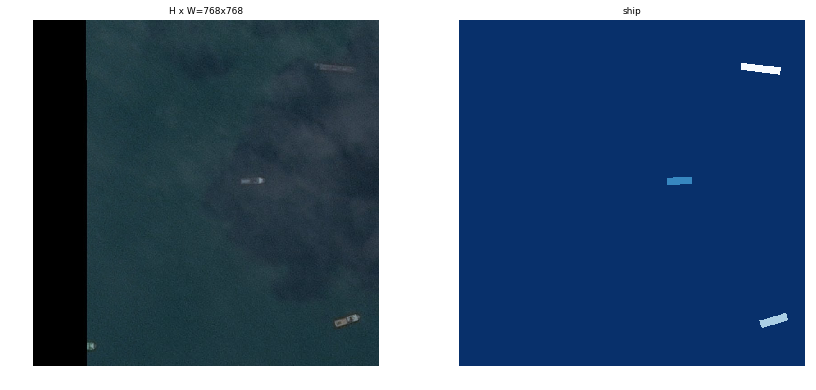

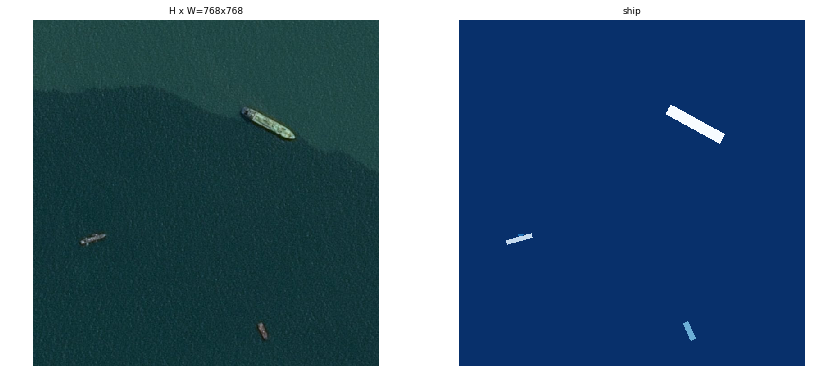

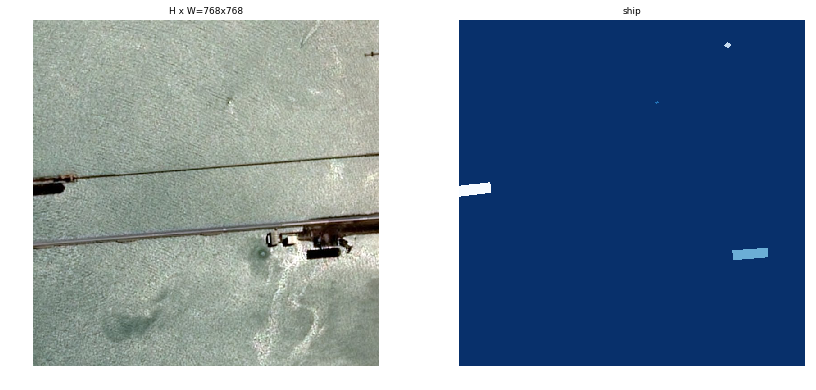

dataset prepare: 9.099424839019775


In [16]:
start_time = time.time()
# Training dataset.
dataset_train = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DATA_PATH, ids=train_ids, masks=masks)
dataset_train.prepare()

# Validation dataset
dataset_val = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DATA_PATH, ids=val_ids, masks=masks)
dataset_val.prepare()

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

In [17]:
start_time = time.time()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=WORKING_DIR)

import errno
try:
    weights_path = model.find_last()
    load_weights = True
except FileNotFoundError:
    # if there is no previous trained weights, load COCO
    load_weights = True
    weights_path = COCO_WEIGHTS_PATH
    utils.download_trained_weights(weights_path)
    
if load_weights:
    print("Loading weights: ", weights_path)
    model.load_weights(weights_path, by_name=True, exclude=[
                "mrcnn_class_logits", "mrcnn_bbox_fc",
                "mrcnn_bbox", "mrcnn_mask"])

end_time = time.time() - start_time
print("loading weights: {}".format(end_time))


... done downloading pretrained model!
Loading weights:  /home/rutu/mask_rcnn_coco.h5
loading weights: 43.280250549316406


In [18]:
"""Train the model."""
start_time = time.time()    
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE * 1.5,
            epochs=21,
            layers='all')
end_time = time.time() - start_time
print("Train model: {}".format(end_time))


Starting at epoch 0. LR=0.0015

Checkpoint Path: /home/rutu/asdc_gpu20190512T1926/mask_rcnn_asdc_gpu_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b        

/home/rutu/anaconda2/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/rutu/anaconda2/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/21


ResourceExhaustedError: OOM when allocating tensor with shape[400,256,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node mrcnn_mask_conv2/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/gradients/mrcnn_mask_conv2/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, mrcnn_mask_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node mul_259/_5417}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_27134_mul_259", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [19]:
class InferenceConfig(AirbusShipDetectionChallengeGPUConfig):
    GPU_COUNT = 1
    # 1 image for inference 
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# create a model in inference mode
infer_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=WORKING_DIR)

model_path = infer_model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
infer_model.load_weights(model_path, by_name=True)


# Test on a random image
image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)

log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = infer_model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

# Compute VOC-Style mean Average Precision @ IoU=0.5
# Running on a few images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
inference_start = time.time()
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = infer_model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])
  # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

inference_end = time.time()
print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
print("mAP: ", np.mean(APs))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


FileNotFoundError: [Errno 2] Could not find weight files in /home/rutu/asdc_gpu20190512T1926